In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [47]:
import math

class ImagePlot:
    def __init__(self, max_columns=5):
        self.reset()
        self.max_columns = max_columns

    def reset(self):
        self.images = []

    def add(self, image, title=""):
        self.images.append({
            "image": image,
            "title": title
        })

    def show(self):
        n_rows = math.ceil(len(self.images) / self.max_columns)
        n_cols = self.max_columns

        plt.figure(figsize=(25, 7))
        for i in range(len(self.images)):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(self.images[i]["image"], cmap="gray")
            plt.title(self.images[i]["title"])
            plt.axis("off")

        plt.show()

plotter = ImagePlot()

In [48]:
data = pd.read_csv("./data/data.csv")

In [49]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
data = data.to_numpy()
data.shape

(42000, 785)

In [51]:
X = data[:, 1:].T
Y = data[:, 0:1].T
print(X.shape, Y.shape)

(784, 42000) (1, 42000)


In [52]:
to_select_idxs = (Y[0] == 0) | (Y[0] == 6) | (Y[0] == 9)
X = X[:, to_select_idxs]
Y = Y[:, to_select_idxs]
print(X.shape, Y.shape)

(784, 12457) (1, 12457)


In [53]:
def train_test_split(X, Y, train_size):
    idxs = np.arange(0, X.shape[1])
    np.random.shuffle(idxs)
    X_train = X[:, idxs[:train_size]]
    Y_train = Y[:, idxs[:train_size]]
    X_test = X[:, idxs[train_size:]]
    Y_test = Y[:, idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test

n_train = int(0.8 * X.shape[1])
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, n_train)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(784, 9965) (1, 9965) (784, 2492) (1, 2492)


In [106]:
def centroid(data):
    return np.expand_dims( np.mean(data, axis=1), 1 )

class PCA:
    def __init__(self):
        self.data_centroid = None
        self.proj_matrix = None

    def fit(self, data, k):
        self.data_centroid = centroid(data)
        centered_data = data - self.data_centroid

        U, _, _ = np.linalg.svd(centered_data, full_matrices=False)
        # Sigma = np.zeros(data.shape)
        # Sigma[:len(s), :len(s)] = np.diag(s)
        # centered_data_k = U[:, :k] @ Sigma[:k, :k] @ Vh[:k, :]
        self.proj_matrix = U[:, :k].T

    def transform(self, data):
        if data.ndim == 1:
            data = np.expand_dims(data, axis=1)
            
        data_centered = data - self.data_centroid
        return self.proj_matrix @ data_centered
    
    def fit_transform(self, data, k):
        self.fit(data, k)
        return self.transform(data)


In [107]:
pca = PCA()
Z_k = pca.fit_transform(X_train, 2)

print(Z_k.shape)


(2, 9965)


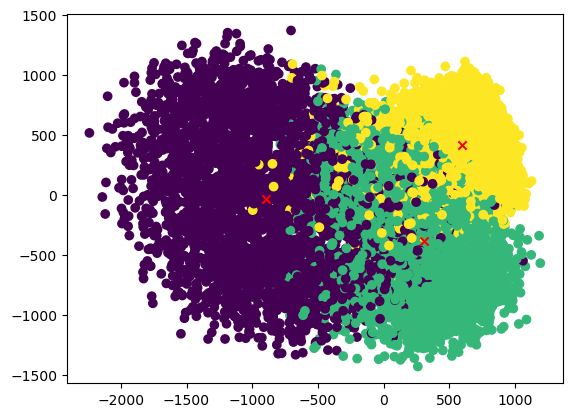

In [108]:
plt.scatter(Z_k[0, :], Z_k[1, :], c=Y_train)

for digit in np.unique(Y_train[0]):
    cluster_centroid = centroid(Z_k[:, Y_train[0] == digit])
    plt.scatter(cluster_centroid[0, :], cluster_centroid[1, :], c="red", marker="x")

plt.show()

In [109]:
for digit in np.unique(Y_train[0]):
    Z_cluster = Z_k[:, Y_train[0] == digit]
    cluster_centroid = centroid(Z_cluster)

    dists = []
    for i in range(Z_cluster.shape[1]):
        dists.append( np.linalg.norm(cluster_centroid - Z_cluster[:, i]) )
    print(f"{digit} | train avg. distance to centroid {np.mean(dists)}")

0 | train avg. distance to centroid 1581.3491620412244
6 | train avg. distance to centroid 1253.1109471769055
9 | train avg. distance to centroid 585.696488895895


In [111]:
Z_k_test = pca.transform(X_test)

for digit in np.unique(Y_test[0]):
    Z_cluster = Z_k_test[:, Y_test[0] == digit]
    cluster_centroid = centroid(Z_cluster)

    dists = []
    for i in range(Z_cluster.shape[1]):
        dists.append( np.linalg.norm(cluster_centroid - Z_cluster[:, i]) )
    print(f"{digit} | test avg. distance to centroid {np.mean(dists)}")

0 | test avg. distance to centroid 1630.6007046885604
6 | test avg. distance to centroid 1243.511913111885
9 | test avg. distance to centroid 585.7925424304251


In [117]:
class MNISTClassifier:
    def __init__(self):
        self.pca = None
        self.Z_k_train = None
        self.possible_digits = None
        self.digits_centroid = None

    def fit(self, X_train, Y_train, k=2):
        self.pca = PCA()
        self.Z_k_train = self.pca.fit_transform(X_train, k)
        self.possible_digits = np.unique(Y_train[0])
        self.digits_centroid = { digit: centroid(self.Z_k_train[:, Y_train[0] == digit]) for digit in self.possible_digits }

    def predict(self, new_digit):
        Z_k_digit = self.pca.transform(new_digit)
        best_distance = +np.inf
        best_digit = None

        for digit in self.possible_digits:
            distance = np.linalg.norm(self.digits_centroid[digit] - Z_k_digit)
            if distance < best_distance:
                best_distance = distance
                best_digit = digit

        return best_digit

In [118]:
classifier = MNISTClassifier()
classifier.fit(X_train, Y_train)

In [123]:
correct = 0
total_digits = X_test.shape[1]

for i in range(total_digits):
    prediction = classifier.predict(X_test[:, i])
    if prediction == Y_test[0, i]:
        correct += 1

print(f"Accuracy: {correct / total_digits} ({correct}/{total_digits} correct)")

Accuracy: 0.8334670947030498 (2077/2492 correct)
